In [1]:
import pickle 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
import requests 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
path = "uci_subset_hmc/uci_subset_hmc"
datasets = ["yacht", "energy", "boston"]

yacht_scale_str = "scale6.0"
boston_scale_str = "scale1.0"
energy_scale_str = "scale4.0"
scale_strs = [yacht_scale_str, energy_scale_str,  boston_scale_str]
gap_seed_strs = [
    ["s2_", "s10_", "s3_", "s5_", "s0_", "s1_"],
    ["s2_", "s10_", "s3_", "s5_", "s0_", "s1_", "s9_", "s7_"],
    ["s13_", "s5_", "s7_", "s1_", "s2_", "s10_", "s3_", "s12_", "s0_", "s32_", "s38_", "s40_", "s41_"]
]


all_results_df_list_not_scaled = []
all_results_df_list_scaled = []

for root, dirs, files in os.walk(path):
    for f in files:
        for dataset, scale_str, gap_seed_list in zip(datasets, scale_strs, gap_seed_strs):
            if dataset in f:
                if scale_str in f:
                    if "_gap" in f:
                        for gs in gap_seed_list:
                            if gs in f:
                                d = pickle.load(open(os.path.join(root, f), "rb"))
                                all_results_df_list_scaled.extend(d["all_results_scaled"])
                                all_results_df_list_not_scaled.extend(d["all_results_not_scaled"])
                    else:
                        d = pickle.load(open(os.path.join(root, f), "rb"))
                        all_results_df_list_scaled.extend(d["all_results_scaled"])
                        all_results_df_list_not_scaled.extend(d["all_results_not_scaled"])
                        
            
all_results_df_scaled = pd.DataFrame(all_results_df_list_scaled)
all_results_df_not_scaled = pd.DataFrame(all_results_df_list_not_scaled)

In [4]:
main_df = all_results_df_not_scaled
main_df["test_nll"] = - main_df["test_ll"]

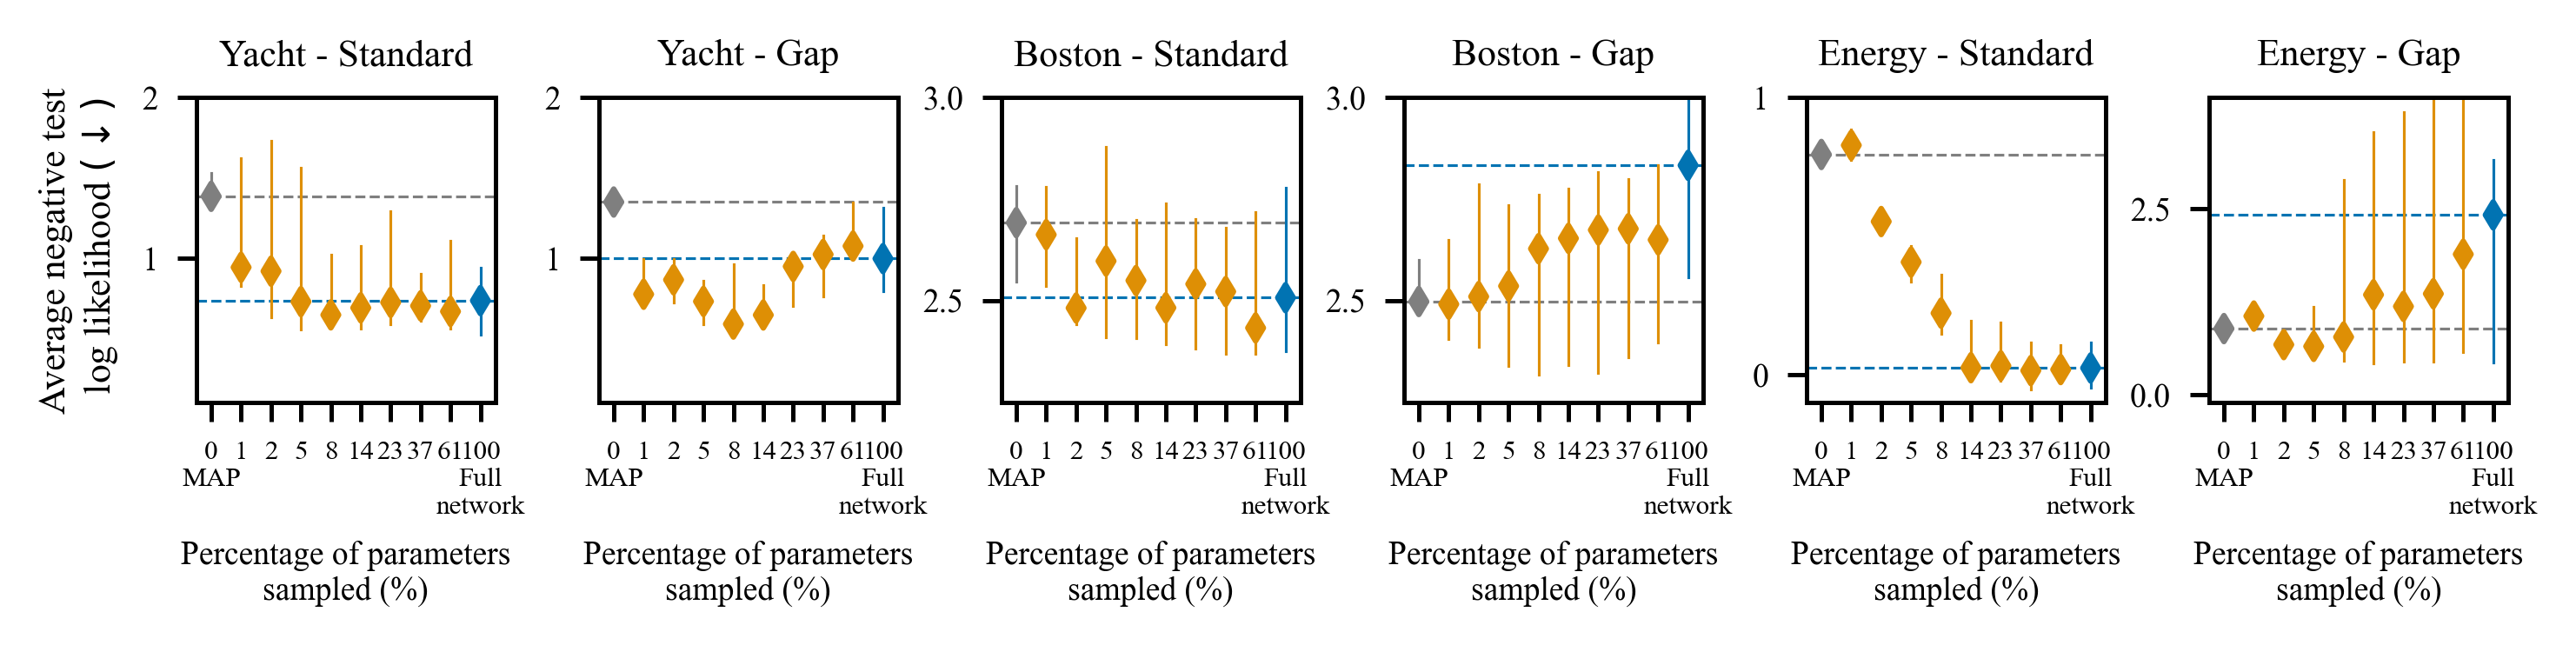

In [12]:
plt.rcParams["font.family"] = "Times New Roman"

custom_colors = ['tab:gray'] 
custom_colors.extend([sns.color_palette('colorblind')[1]]*8) 
custom_colors.append(sns.color_palette('colorblind')[0])

plt.figure(figsize=(6.75, 1.75), dpi=450)

def create_subplot_df(main_df, gap=False, dataset="yacht"):
    subplot_df = main_df[
        (main_df["gap_split?"]==gap) &
        (main_df["dataset"]==dataset)
    ]
    
    num_params = np.sort(subplot_df["num_params_sampled"].unique())

    num_param_ticks = ["0\nMAP", "0.1", "0.2", "0.3", "0.4", "0.7", "1", "2", 
                       "3", "5", "8", "14", "23", "37", "61", "99", "100\nFull\nnetwork"]
    
    num_params, labels = list(zip(*[(num_params[i], num_param_ticks[i]) for i in [0,6,7,9,10,11,12,13,14,16]]))
    
    subplot_df = subplot_df[subplot_df["num_params_sampled"].isin(num_params)]
    
    return subplot_df, num_params, labels
        
def format_plot(ylabel=False, ylim=None):
    plt.xlabel("Percentage of parameters\nsampled (%)", fontsize=6)
    if ylabel:
        plt.ylabel("Average negative test\n log likelihood $(\\downarrow)$", fontsize=7)
    else:
        y=plt.ylabel("")
    plt.xticks(np.arange(len(num_params)), labels, fontsize=5)
    # plt.yscale('symlog')
    if ylim:
        plt.ylim(ylim)
    plt.yticks(fontsize=6)

def create_plot_from_df():    
    def iqr(x):
        return np.percentile(x, [25, 75])
    
    sns.pointplot(errorbar=iqr,
        data=subplot_df, x="num_params_sampled", y="test_nll", 
        join=False, palette=custom_colors,
        markers="d", scale=.5, errwidth=0.5, estimator=np.median)
    
    fs_np = subplot_df["num_params_sampled"].max()
    plt.axhline(subplot_df[subplot_df["num_params_sampled"]==fs_np]["test_nll"].median(), color=custom_colors[-1], 
                zorder=-3, linewidth=0.5, linestyle='--')
    
    fd_np = subplot_df["num_params_sampled"].min()
    plt.axhline(subplot_df[subplot_df["num_params_sampled"]==fd_np]["test_nll"].median(), color=custom_colors[0], 
                zorder=-1, linewidth=0.5, linestyle='--')
    
    
plt.subplot(161)    
subplot_df, num_params, labels = create_subplot_df(main_df, False, "yacht")
create_plot_from_df()
format_plot(True, ylim=[0.1, 2])      
plt.title("Yacht - Standard", fontsize=7)

plt.subplot(162)    
subplot_df, num_params, labels = create_subplot_df(main_df, True, "yacht")
create_plot_from_df()
format_plot(ylim=[0.1, 2])      
plt.title("Yacht - Gap", fontsize=7)

plt.subplot(163)    
subplot_df, num_params, labels = create_subplot_df(main_df, False, "boston")
create_plot_from_df()
format_plot(ylim=[2.25, 3])      
plt.title("Boston - Standard", fontsize=7)

plt.subplot(164)    
subplot_df, num_params, labels = create_subplot_df(main_df, True, "boston")
create_plot_from_df()
format_plot(ylim=[2.25, 3])      
plt.title("Boston - Gap", fontsize=7)

plt.subplot(165)    
subplot_df, num_params, labels = create_subplot_df(main_df, False, "energy")
create_plot_from_df()
format_plot(ylim=[-0.1, 1])      
plt.title("Energy - Standard", fontsize=7)

plt.subplot(166)    
subplot_df, num_params, labels = create_subplot_df(main_df, True, "energy")
create_plot_from_df()
format_plot(ylim=[-0.1, 4])      
plt.title("Energy - Gap", fontsize=7)

plt.tight_layout(w_pad=-0.1)
plt.savefig('subset_hmc.pdf', bbox_inches='tight')